In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf

### Define Training Parameters

In [3]:
batch_size = 128  # Batch size
sequence_length = 100  # Number of steps
learning_rate = 0.001  # 0.0001
epochs = 100
ann_hidden = 50
n_channels = 24
lstm_size = n_channels * 3  # 3 times the amount of channels

initializer = tf.initializers.GlorotUniform()
MAXLIFE = 120

### Formatting and Saving training and test data

In [4]:
training_data = np.load("Processed_Data/FD001_normalized_train_data_Aug.npy")
testing_data = np.load("Processed_Data/FD001_normalized_test_data.npy")

x_train = training_data[:, :training_data.shape[1] - 1]
y_train = training_data[:, training_data.shape[1] - 1]
print("training data: ", x_train.shape, y_train.shape)

x_test = testing_data[:, :testing_data.shape[1] - 1]
y_test = testing_data[:, testing_data.shape[1] - 1]
print("testing data: ", x_test.shape, y_test.shape)

training data:  (63047, 24) (63047,)
testing data:  (33727, 24) (33727,)


In [5]:
def batch_generator(x_train, y_train, batch_size, sequence_length, online=False, online_shift=1):
    """
    Generator function for creating random batches of training-data for many to many models
    """
    num_x_sensors = x_train.shape[1]
    num_train = x_train.shape[0]
    idx = 0

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_sensors)
        x_batch = np.zeros(shape=x_shape, dtype=np.float32)
        # print(idx)
        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length)
        y_batch = np.zeros(shape=y_shape, dtype=np.float32)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            if online == True and (idx >= num_train or (idx + sequence_length) > num_train):
                idx = 0
            elif online == False:
                idx = np.random.randint(num_train - sequence_length)

            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train[idx:idx + sequence_length]
            y_batch[i] = y_train[idx:idx + sequence_length]
            # print(i,idx)
            if online:
                idx = idx + online_shift  # check if its nee to be idx=idx+1
                # print(idx)
        # print(idx)
        yield (x_batch, y_batch)

In [6]:
## Generating Training batches
print("Training batch generation")
training_generator = batch_generator(x_train, y_train, batch_size, sequence_length, online=True)

x_train_shape = (0, sequence_length, x_train.shape[1])
y_train_shape = (0, sequence_length,)
x_train_reshaped = np.zeros(shape=x_train_shape, dtype=np.float32)
y_train_reshaped = np.zeros(shape=y_train_shape, dtype=np.float32)

iteration = int(x_train.shape[0] / batch_size)
for itr in range(iteration):
    x_train_batch, y_train_batch = next(training_generator)
    x_train_reshaped = np.concatenate((x_train_reshaped, x_train_batch), axis=0)
    y_train_reshaped = np.concatenate((y_train_reshaped, y_train_batch), axis=0)
    # print(x_train_batch.shape, y_train_batch.shape)
    # print(x_train_reshaped.shape, y_train_reshaped.shape)

print(x_train_reshaped.shape, y_train_reshaped.shape)

## Generating Test/Validtaion batches
print("Testing batch generation")
# testing_generator = batch_generator(x_test, y_test, batch_size, sequence_length, online=False)
testing_generator = batch_generator(x_test, y_test, batch_size, sequence_length, online=True, online_shift=sequence_length)

x_test_shape = (0, sequence_length, x_train.shape[1])
y_test_shape = (0, sequence_length,)
x_test_reshaped = np.zeros(shape=x_test_shape, dtype=np.float32)
y_test_reshaped = np.zeros(shape=y_test_shape, dtype=np.float32)

iteration = max(int(x_test.shape[0] / (batch_size * sequence_length)), 1)
for itr in range(iteration):
    x_test_batch, y_test_batch = next(testing_generator) 
    x_test_reshaped = np.concatenate((x_test_reshaped, x_test_batch), axis=0)
    y_test_reshaped = np.concatenate((y_test_reshaped, y_test_batch), axis=0)
    # print(x_test_batch.shape, y_test_batch.shape)
    # print(x_test_reshaped.shape, y_test_reshaped.shape)

print(x_test_reshaped.shape, y_test_reshaped.shape)

np.savez('Processed_Data/FD001_normalized_batch_data.npz', 
            x_train_reshaped=x_train_reshaped, y_train_reshaped=y_train_reshaped, 
            x_test_reshaped=x_test_reshaped, y_test_reshaped=y_test_reshaped)

Training batch generation
(62976, 100, 24) (62976, 100)
Testing batch generation
(256, 100, 24) (256, 100)


### Single Layer LSTM Model

In [8]:
initializer = tf.initializers.GlorotUniform(seed=0)
model_lstm = tf.keras.models.Sequential([
                tf.keras.layers.RNN(
                    tf.keras.layers.LSTMCell(lstm_size, kernel_initializer= initializer, dropout=0.2),
                                return_sequences=True, input_shape=(sequence_length, n_channels)),
                tf.keras.layers.Dense(ann_hidden, activation='relu'),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1)])

# print(model_cnn)
print("Model Summary")
print(model_lstm.summary())

model_lstm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss = 'mean_squared_error', metrics=['mse', 'mae'])

Model Summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, 100, 72)           27936     
                                                                 
 dense (Dense)               (None, 100, 50)           3650      
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 dense_1 (Dense)             (None, 100, 1)            51        
                                                                 
Total params: 31,637
Trainable params: 31,637
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
epochs = 50
iteration = int(x_train_reshaped.shape[0] / batch_size)

path_checkpoint = 'Saved_Model/FD001_1lstm_batch128/'
if not os.path.exists(os.path.dirname(path_checkpoint)):
    os.makedirs(os.path.dirname(path_checkpoint))

history_lstm = model_lstm.fit(x_train_reshaped, y_train_reshaped, batch_size= batch_size, steps_per_epoch=iteration, epochs=epochs,
    validation_data = (x_test_reshaped, y_test_reshaped), verbose=2, use_multiprocessing=False)

tf.keras.models.save_model(model_lstm, path_checkpoint,overwrite=True,include_optimizer=True,save_format=None,signatures=None,options=None )
model_lstm.save(os.path.join(path_checkpoint,'model_lstm.h5'))

Epoch 1/50
492/492 - 48s - loss: 1794.9196 - mse: 1794.9196 - mae: 28.4049 - val_loss: 400.0197 - val_mse: 400.0197 - val_mae: 12.9965 - 48s/epoch - 97ms/step
Epoch 2/50
492/492 - 42s - loss: 287.1466 - mse: 287.1466 - mae: 12.5015 - val_loss: 339.5819 - val_mse: 339.5819 - val_mae: 11.8153 - 42s/epoch - 85ms/step
Epoch 3/50
492/492 - 41s - loss: 249.7852 - mse: 249.7852 - mae: 11.8021 - val_loss: 299.3125 - val_mse: 299.3125 - val_mae: 10.7378 - 41s/epoch - 84ms/step
Epoch 4/50
492/492 - 40s - loss: 229.1111 - mse: 229.1111 - mae: 11.3839 - val_loss: 300.1541 - val_mse: 300.1541 - val_mae: 10.7868 - 40s/epoch - 82ms/step
Epoch 5/50
492/492 - 41s - loss: 216.4402 - mse: 216.4402 - mae: 11.1050 - val_loss: 291.4045 - val_mse: 291.4045 - val_mae: 10.3544 - 41s/epoch - 83ms/step
Epoch 6/50
492/492 - 41s - loss: 208.0973 - mse: 208.0973 - mae: 10.9149 - val_loss: 286.2576 - val_mse: 286.2576 - val_mae: 10.0362 - 41s/epoch - 84ms/step
Epoch 7/50
492/492 - 41s - loss: 200.2168 - mse: 200.216

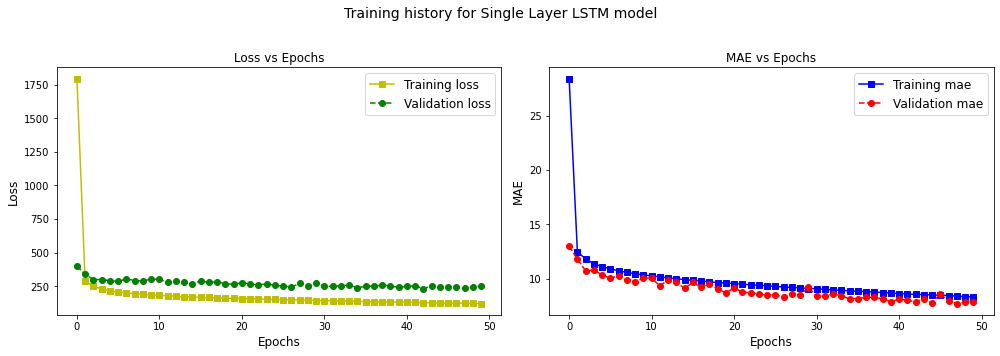

In [10]:
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
mae = history_lstm.history['mae']
val_mae = history_lstm.history['val_mae']
epochs = range(len(loss))
                        
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(epochs, loss, 'ys-', label='Training loss')
ax[0].plot(epochs, val_loss, 'go--', label='Validation loss')
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].set_title('Loss vs Epochs', fontsize=12)
ax[0].legend(fontsize=12, loc='best')

ax[1].plot(epochs, mae, 'bs-', label='Training mae')
ax[1].plot(epochs, val_mae, 'ro--', label='Validation mae')
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('MAE', fontsize=12)
ax[1].set_title('MAE vs Epochs', fontsize=12)
ax[1].legend(fontsize=12, loc='best')

plt.suptitle("Training history for Single Layer LSTM model\n", fontsize=14)
plt.savefig('{}/LSTM history'.format(path_checkpoint))

fig.tight_layout()
plt.show()

### 3 CNN - LSTM Layers Model 
(as per paper: https://arxiv.org/abs/1810.05644)

In [12]:
model_cnnlstm = tf.keras.models.Sequential([
                tf.keras.layers.Conv1D(filters=18,kernel_size=2,strides=1,padding="same",
                                       kernel_initializer=initializer,activation="relu",input_shape=[sequence_length, n_channels]),
                tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="same"),
                tf.keras.layers.Conv1D(filters=36,kernel_size=2,strides=1,padding="same",
                                       kernel_initializer=initializer,activation="relu"),
                tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="same"),
                tf.keras.layers.Conv1D(filters=72,kernel_size=2,strides=1,padding="same",
                                       kernel_initializer=initializer,activation="relu"),
                tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="same"),
                tf.keras.layers.Flatten(),

                tf.keras.layers.Dense(sequence_length*n_channels,activation='relu'),
                tf.keras.layers.Dropout(0.2),

                tf.keras.layers.Reshape((sequence_length, n_channels)),
                tf.keras.layers.RNN(
                    tf.keras.layers.LSTMCell(lstm_size, kernel_initializer= initializer, dropout=0.2),
                                return_sequences=True, input_shape=(-1, sequence_length, n_channels)),
                
                tf.keras.layers.Reshape((-1, lstm_size)),
                tf.keras.layers.Dense(ann_hidden, activation='relu'),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1)])

# print(model_cnn)
print("Model Summary")
print(model_cnnlstm.summary())

model_cnnlstm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss = 'mean_squared_error', metrics=['mse', 'mae'])


Model Summary
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 18)           882       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 18)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 36)            1332      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 36)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 72)            5256      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 13,

In [13]:
iteration = int(x_train_reshaped.shape[0] / batch_size)
path_checkpoint = 'Saved_Model/FD001_3CNN_lstm_batch128/'
if not os.path.exists(os.path.dirname(path_checkpoint)):
    os.makedirs(os.path.dirname(path_checkpoint))

epochs = 50
history_cnnlstm = model_cnnlstm.fit(x_train_reshaped, y_train_reshaped, batch_size= batch_size, steps_per_epoch=iteration, epochs=epochs,
    validation_data = (x_test_reshaped, y_test_reshaped), verbose=2, use_multiprocessing=False)

tf.keras.models.save_model(model_cnnlstm, path_checkpoint,overwrite=True,include_optimizer=True,save_format=None,signatures=None,options=None )
model_cnnlstm.save(os.path.join(path_checkpoint,'model_cnnlstm.h5'))

Epoch 1/50
492/492 - 68s - loss: 1875.3246 - mse: 1875.3246 - mae: 29.4158 - val_loss: 164.1908 - val_mse: 164.1908 - val_mae: 8.4454 - 68s/epoch - 138ms/step
Epoch 2/50
492/492 - 62s - loss: 203.9726 - mse: 203.9726 - mae: 10.8670 - val_loss: 124.8155 - val_mse: 124.8155 - val_mae: 7.1331 - 62s/epoch - 126ms/step
Epoch 3/50
492/492 - 62s - loss: 172.2755 - mse: 172.2755 - mae: 10.0566 - val_loss: 109.7853 - val_mse: 109.7853 - val_mae: 6.5464 - 62s/epoch - 127ms/step
Epoch 4/50
492/492 - 66s - loss: 152.1403 - mse: 152.1403 - mae: 9.5073 - val_loss: 124.2570 - val_mse: 124.2570 - val_mae: 6.4907 - 66s/epoch - 135ms/step
Epoch 5/50
492/492 - 71s - loss: 143.7083 - mse: 143.7083 - mae: 9.2701 - val_loss: 118.8321 - val_mse: 118.8321 - val_mae: 6.0316 - 71s/epoch - 145ms/step
Epoch 6/50
492/492 - 66s - loss: 133.9541 - mse: 133.9541 - mae: 8.9185 - val_loss: 133.4723 - val_mse: 133.4723 - val_mae: 6.1924 - 66s/epoch - 134ms/step
Epoch 7/50
492/492 - 62s - loss: 130.4012 - mse: 130.4012 -

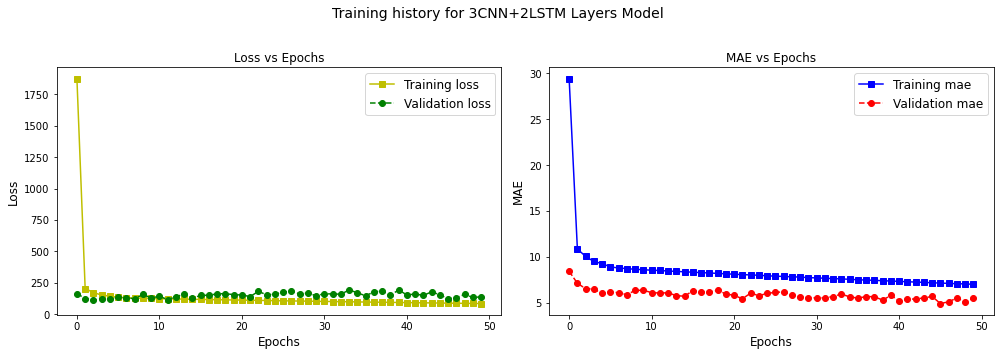

In [14]:
loss = history_cnnlstm.history['loss']
val_loss = history_cnnlstm.history['val_loss']
mae = history_cnnlstm.history['mae']
val_mae = history_cnnlstm.history['val_mae']
epochs = range(len(loss))
                        
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(epochs, loss, 'ys-', label='Training loss')
ax[0].plot(epochs, val_loss, 'go--', label='Validation loss')
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].set_title('Loss vs Epochs', fontsize=12)
ax[0].legend(fontsize=12, loc='best')

ax[1].plot(epochs, mae, 'bs-', label='Training mae')
ax[1].plot(epochs, val_mae, 'ro--', label='Validation mae')
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('MAE', fontsize=12)
ax[1].set_title('MAE vs Epochs', fontsize=12)
ax[1].legend(fontsize=12, loc='best')

plt.suptitle("Training history for 3CNN+2LSTM Layers Model \n", fontsize=14)
plt.savefig('{}/CNNLSTM history'.format(path_checkpoint))

fig.tight_layout()
plt.show()

## Model Results

### Single Layer LSTM model

In [15]:
## Predicting on the test set
lstm_predictions = model_lstm.predict(x_test_reshaped).reshape(-1,1)

## Adding the predictions on the test dataframe with metadata
test = pd.read_csv("Processed_Data/FD001_normalized_test_data.csv")
test_lstm = test.loc[:lstm_predictions.shape[0]-1, ['engine_id', 'cycle', 'RUL']]
test_lstm['LSTM_Predictions'] = lstm_predictions[:test_lstm.shape[0]]

8/8 [==============================] - 1s 19ms/step


Text(0.5, 1.0, 'Actual vs Predicted for Single Layer LSTM Model')

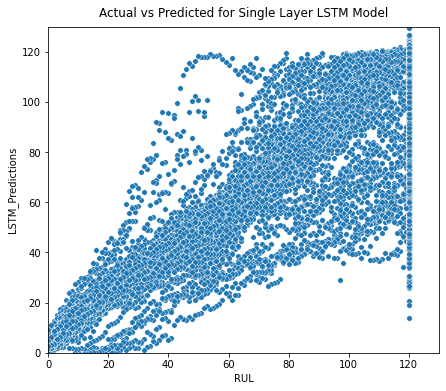

In [16]:
## Actual vs Predicted plot
fig, ax = plt.subplots(1, figsize=(7, 6), facecolor='white')
sns.scatterplot(data=test_lstm, x='RUL', y='LSTM_Predictions', s=30, ax=ax)
ax.set(xlim=(0, 130), ylim=(0, 130))
ax.set_title('Actual vs Predicted for Single Layer LSTM Model', pad=10)

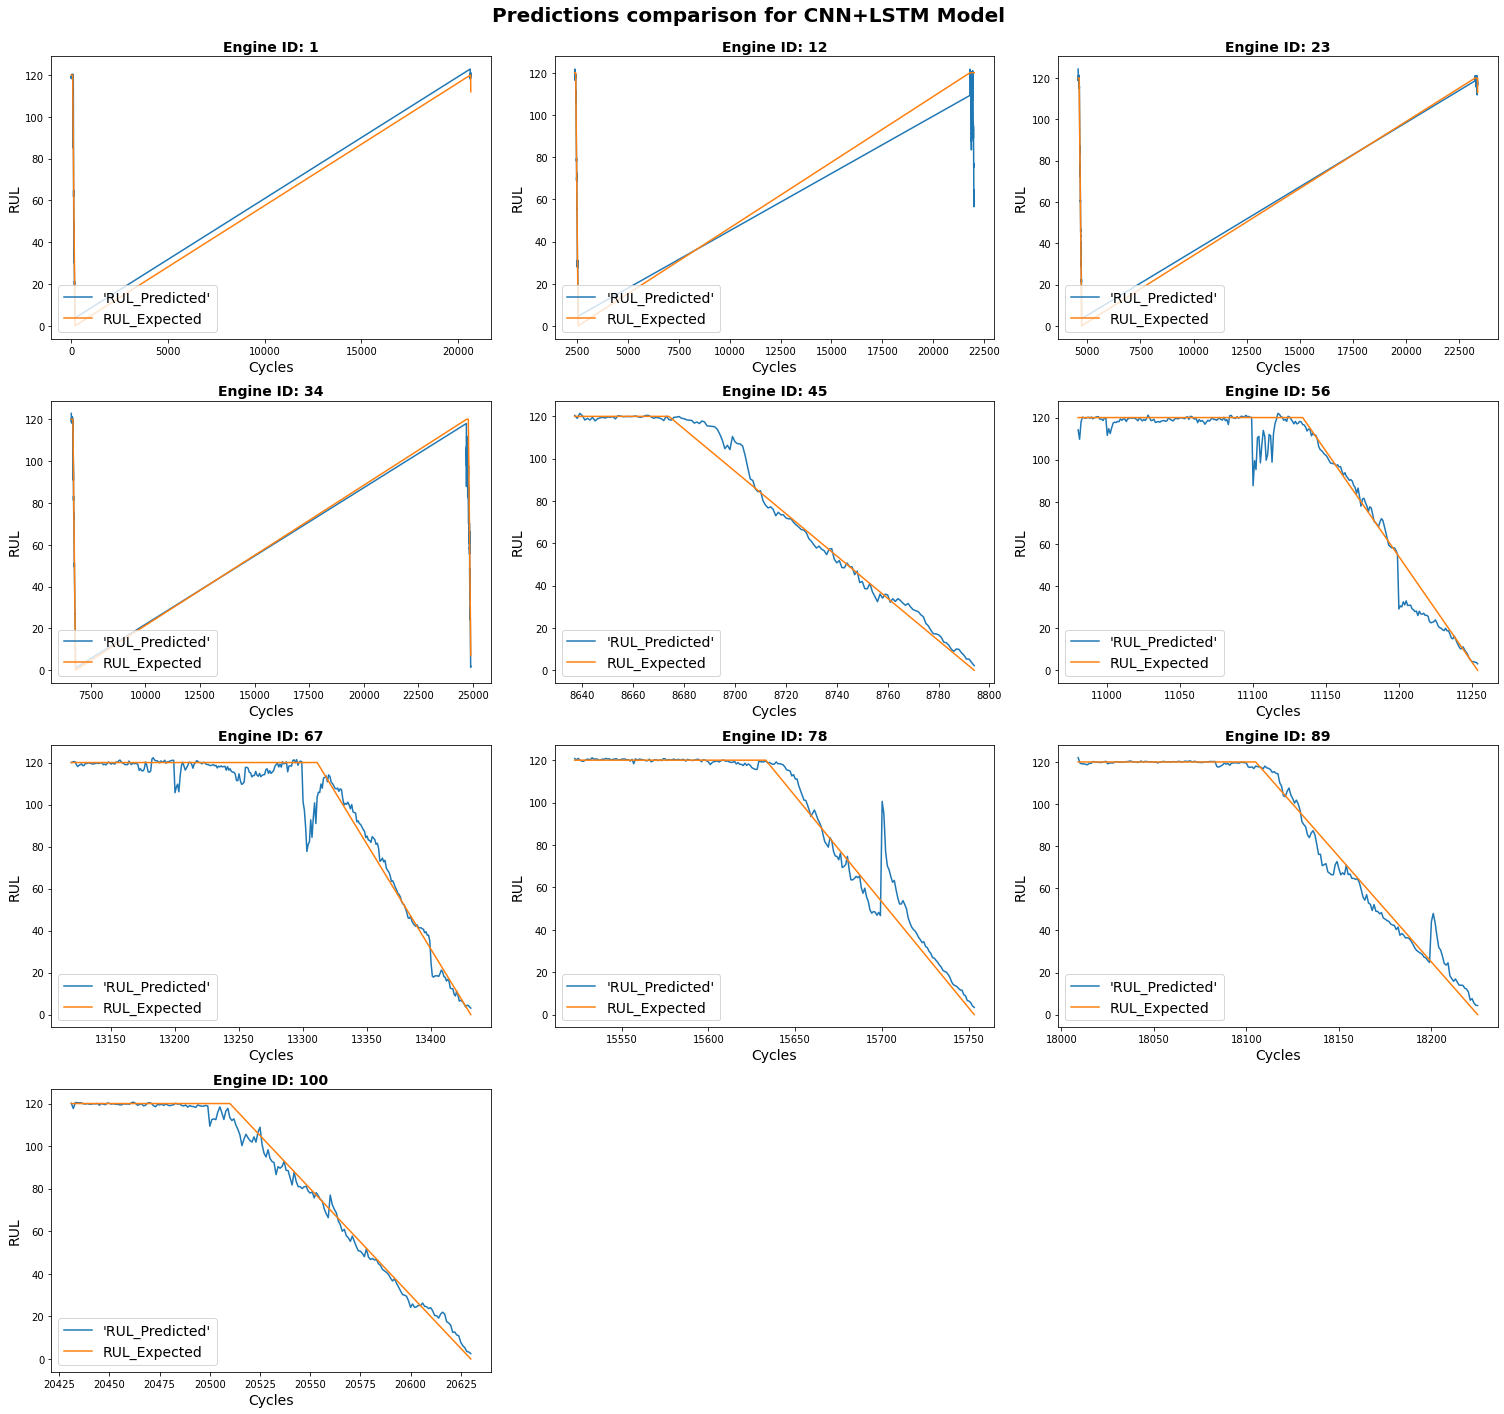

In [17]:
## Timeseries plots
engine_ID_plot = list(test_lstm['engine_id'].unique())[0:100:11]
subplot_cols = 3
fig = plt.figure(figsize=(7*subplot_cols, 5*(len(engine_ID_plot)// subplot_cols + 1)))

for i in  range(len(engine_ID_plot)):

    ax = fig.add_subplot(len(engine_ID_plot) // subplot_cols + 1, subplot_cols, i + 1)
    id = engine_ID_plot[i]

    ax.plot(test_lstm.loc[test_lstm['engine_id'] == id, 'LSTM_Predictions'], label="'RUL_Predicted'")
    ax.plot(test_lstm.loc[test_lstm['engine_id'] == id, 'RUL'],label="RUL_Expected")
    ax.set_xlabel('Cycles', fontsize=14)
    ax.set_ylabel('RUL', fontsize=14)
    ax.set_title(('Engine ID: {}'.format(id)), pad = 5, fontsize=14, fontweight = 'bold')
    plt.legend(loc='lower left', fontsize=14)

plt.suptitle("Predictions comparison for CNN+LSTM Model \n", fontsize=20, fontweight = 'bold')
fig.tight_layout()
plt.show()

### CNN-LSTM Model

In [19]:
## Predicting on the test set
cnnlstm_predictions = model_cnnlstm.predict(x_test_reshaped).reshape(-1,1)

## Adding the predictions on the test dataframe with metadata
test = pd.read_csv("Processed_Data/FD001_normalized_test_data.csv")
test_cnnlstm = test.loc[:cnnlstm_predictions.shape[0]-1, ['engine_id', 'cycle', 'RUL']]
test_cnnlstm['cnnlstm_Predicted'] = cnnlstm_predictions

8/8 [==============================] - 0s 27ms/step


In [26]:
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(test_cnnlstm['RUL'], test_cnnlstm['cnnlstm_Predicted'], squared=False)
print('Root Mean Squared Error of the CNN-LSTM model = ', rms)

Root Mean Squared Error of the CNN-LSTM model =  11.750399029854623


Text(0.5, 1.0, 'Actual vs Predicted for CNN+LSTM Model')

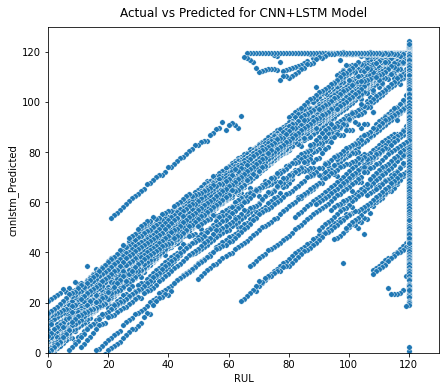

In [20]:
## Actual vs Predicted plot
fig, ax = plt.subplots(1, figsize=(7, 6), facecolor='white')
sns.scatterplot(data=test_cnnlstm, x='RUL', y='cnnlstm_Predicted', s=30, ax=ax)
ax.set(xlim=(0, 130), ylim=(0, 130))
ax.set_title('Actual vs Predicted for CNN+LSTM Model', pad=10)

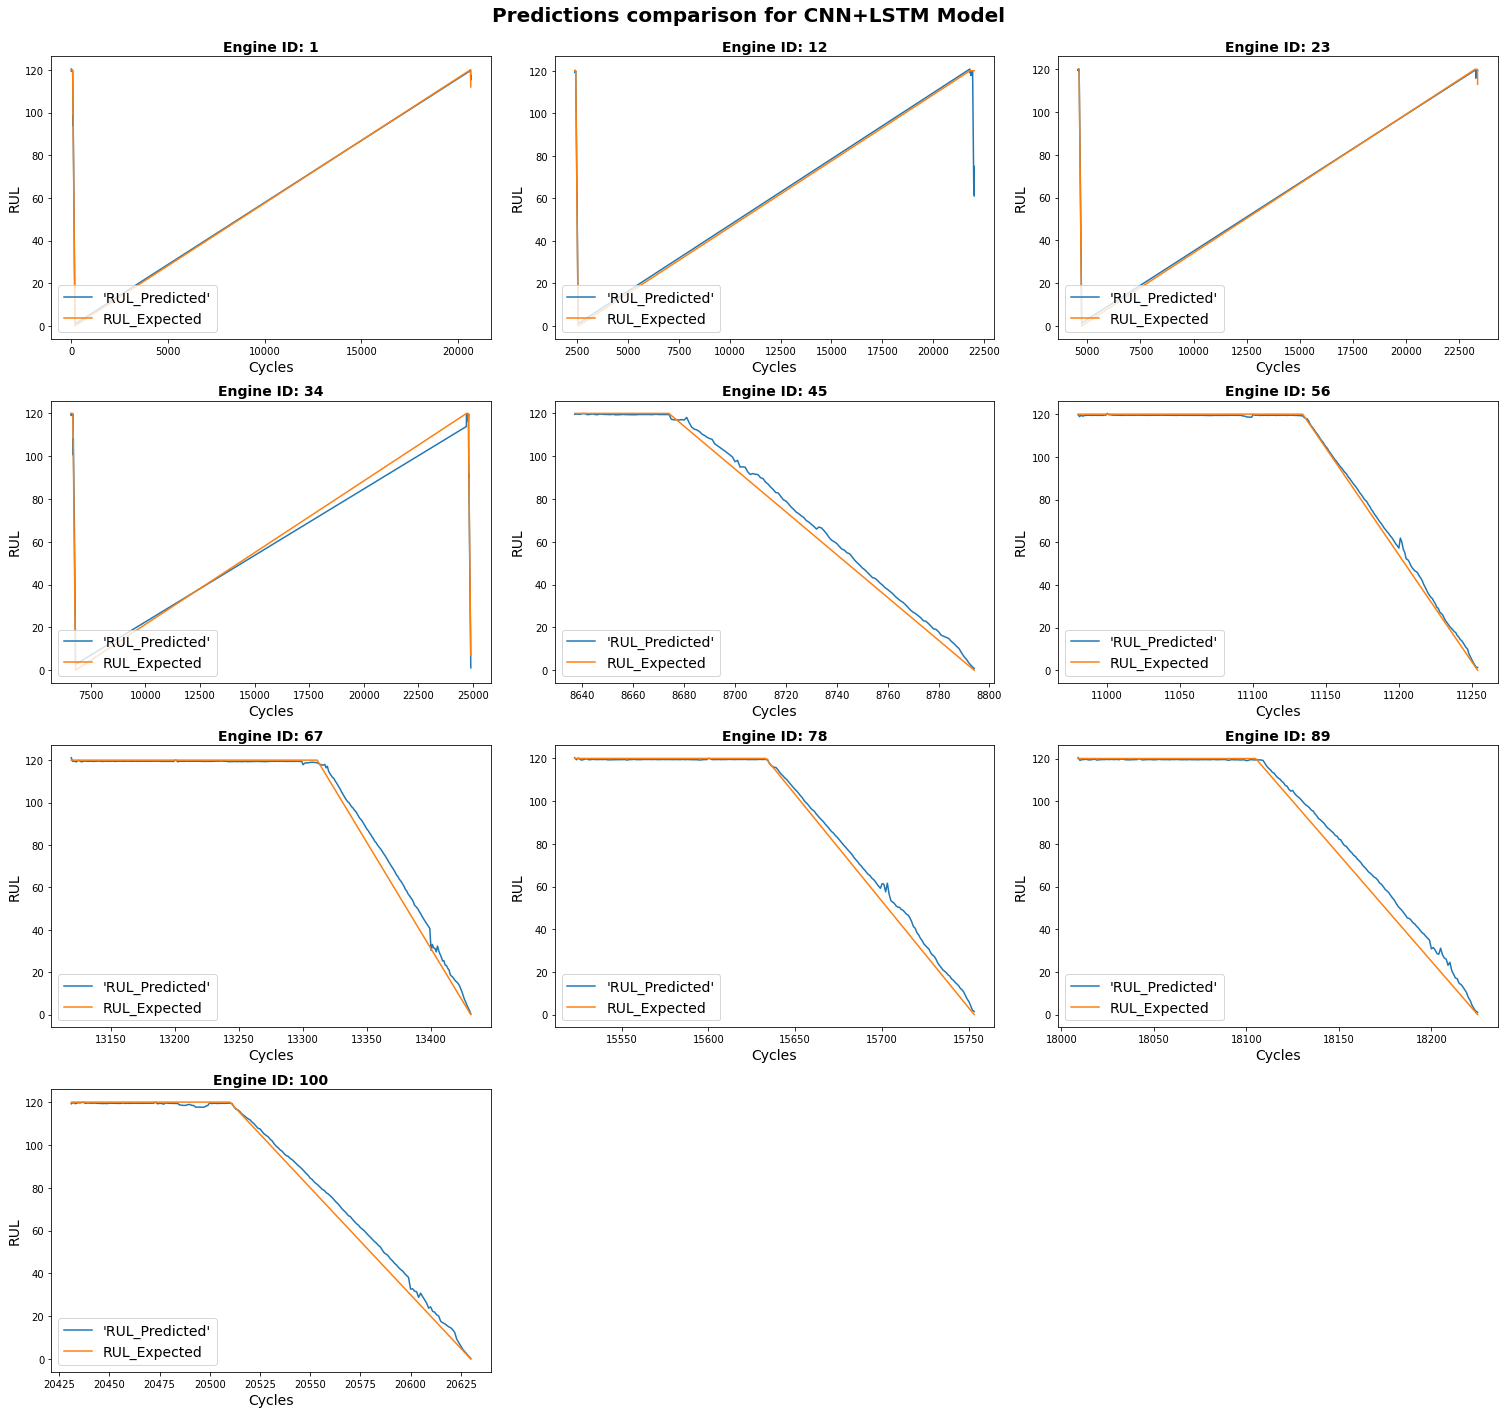

In [21]:
## Timeseries plots
engine_ID_plot = list(test_cnnlstm['engine_id'].unique())[0:100:11]
subplot_cols = 3
fig = plt.figure(figsize=(7*subplot_cols, 5*(len(engine_ID_plot)// subplot_cols + 1)))

for i in  range(len(engine_ID_plot)):

    ax = fig.add_subplot(len(engine_ID_plot) // subplot_cols + 1, subplot_cols, i + 1)
    id = engine_ID_plot[i]

    ax.plot(test_cnnlstm.loc[test_cnnlstm['engine_id'] == id, 'cnnlstm_Predicted'], label="'RUL_Predicted'")
    ax.plot(test_cnnlstm.loc[test_cnnlstm['engine_id'] == id, 'RUL'],label="RUL_Expected")
    ax.set_xlabel('Cycles', fontsize=14)
    ax.set_ylabel('RUL', fontsize=14)
    ax.set_title(('Engine ID: {}'.format(id)), pad = 5, fontsize=14, fontweight = 'bold')
    plt.legend(loc='lower left', fontsize=14)

plt.suptitle("Predictions comparison for CNN+LSTM Model \n", fontsize=20, fontweight = 'bold')
fig.tight_layout()
plt.show()

## Findings

 This project demonstrated use of advanced neural networks based model to estimate the RUL of the industrain machine. 

* The system architecture includes a combination of temporal convolution layers and LSTM layers was evaluated on the publicly available NASA Commercial Modular AeroPropulsion System Simulation dataset (C-MAPSS). 

* Model trained using augmented training set gave better predictions compared to the model trained on non-augmented data. 

* The model (with 3 CNN layers and 2 LSTM layers) proposed in the paper https://arxiv.org/abs/1810.05644  have better performance on the test set compared to the model with only 1 LSTM layer. 

* The Root Mean Square Error of the CNN-LSTM model trained on the augmented data was 11.75.

* The CNN-LSTM model can be used for in-situ monitoring of the machine components with various failure mode.  

* The trained model can be deployed to provide the machine operators a more accurate maintenance schedule by estimating RUL which can reduce the cost and downtime and imrpove productivity. 

* It can also be used to avoid catastrophic failures of the machines and improve safety of the operators and users.

## Next Steps

* Improve understanding of LSTM layers and physical understandings of sequence length and batch size.

* Use Keras Tuner or Optuna hyper parameter tuning.

* Optimize the code to run on GPUs and train the model on system with multiple GPUs. 

* Evaluation the model on the other sub-datasets (FD002, FD003, FD004). The FD002 and FD004 datasets have six operating
conditions and the complex relations among sensors. Hence this evaluation is important to assess the robustness of the model.

